In [1]:
%load_ext jupyter_black
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sh_geom

# Get data from database

In [2]:
raw_db = pd.read_excel(
    "/home/jupyter/ee_segmentation/notebooks/data prep/Global-Wind-Power-Tracker-May-2023.xlsx",
    "Data",
    usecols="B,C,G,H,I,J,P,Q,R",
)
turbine_type = ["offshore floating", "offshore hard mount", "offshore mount unknown"]
offshore_db = raw_db[raw_db["Installation Type"].isin(turbine_type)]
active_offshore_db = offshore_db[offshore_db["Status"] == "operating"]
active_offshore_db_accurate = active_offshore_db[
    active_offshore_db["Location accuracy"] == "exact"
]

In [3]:
active_offshore_db_accurate

,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy
481,Japan,Kamis Offshore wind farm,14.0,offshore hard mount,operating,2010.0,35.8905,140.7297,exact
482,Japan,Kamis Offshore wind farm,16.0,offshore hard mount,operating,2013.0,35.9025,140.7209,exact
585,Japan,Sakata North Port (Nearshore) Offshore wind farm,16.0,offshore hard mount,operating,2014.0,38.9689,139.8231,exact
1212,Taiwan,Formosa 1 offshore wind farm,120.0,offshore hard mount,operating,2019.0,24.7092,120.8151,exact
1351,Vietnam,Bạc Liêu Offshore wind farm,16.0,offshore hard mount,operating,2013.0,9.2367,105.8223,exact
...,...,...,...,...,...,...,...,...,...
20920,United Kingdom,Walney wind farm,184.0,offshore hard mount,operating,2012.0,54.0807,-3.6090,exact
20940,United Kingdom,West Of Duddon Sands wind farm,389.0,offshore hard mount,operating,2014.0,53.9851,-3.4620,exact
20943,United Kingdom,Westermost Rough A wind farm,210.0,offshore hard mount,operating,2015.0,53.0977,0.5615,exact
21657,United States,Block Island wind farm,30.0,offshore hard mount,operating,2016.0,41.1199,-71.5139,exact


In [4]:
# around 105
train_id = [
    0,
    14,
    9,
    1,
    32,
    30,
    33,
    23,
    24,
    35,
    15,
    19,
    16,
    17,
    18,
    11,
    12,
    13,
    76,
    83,
    78,
    47,
    46,
    54,
    48,
    57,
    53,
    64,
    45,
    52,
    55,
    56,
    58,
    59,
    60,
    61,
    62,
    37,
    42,
    67,
    65,
    66,
    71,
    72,
    69,
    88,
    84,
    85,
    87,
    100,
    101,
    98,
    95,
    89,
    99,
    96,
    91,
    108,
    131,
    107,
    121,
    124,
    122,
    119,
    118,
    128,
    123,
    105,
    110,
    111,
    130,
    114,
    120,
    104,
    117,
    135,
    134,
    133,
    142,
    140,
    3,
    4,
    163,
    154,
    167,
    150,
    176,
    149,
    166,
    162,
    180,
    160,
    171,
    178,
    179,
    146,
    165,
    143,
    161,
    181,
    170,
    144,
    147,
    169,
    157,
]
# around 30
val_id = [
    22,
    34,
    10,
    80,
    82,
    63,
    43,
    40,
    38,
    68,
    73,
    74,
    86,
    97,
    90,
    93,
    92,
    115,
    113,
    112,
    127,
    126,
    139,
    141,
    8,
    173,
    152,
    177,
    184,
    145,
    175,
]
# around 15
test_id = [79, 81, 51, 70, 94, 102, 116, 109, 132, 137, 6, 158, 174, 186, 185]

In [5]:
raw_geometry = pd.read_csv(
    "/home/jupyter/ee_segmentation/notebooks/data prep/Wind_farm_lon_lat_geometry_batch1.csv",
    header=None,
)

,0,1,2,3,4,5,6,7
0,38,121.1333,33.3083,0.100,01/01/2022,31/03/2022,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.233..."
1,38,121.1333,33.3083,0.100,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.181..."
2,40,121.3750,33.4600,0.075,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
3,40,121.3750,33.4600,0.075,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
4,42,121.5927,33.3225,0.080,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.5127...","[{'type': 'Polygon', 'coordinates': [[[121.669..."
...,...,...,...,...,...,...,...,...
298,34,113.7300,22.1200,0.050,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.68, ...","[{'type': 'Polygon', 'coordinates': [[[113.716..."
299,35,113.4370,21.9075,0.070,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.367,...","[{'type': 'Polygon', 'coordinates': [[[113.384..."
300,35,113.4370,21.9075,0.070,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.367,...","[{'type': 'Polygon', 'coordinates': [[[113.383..."
301,37,121.4700,33.1600,0.100,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.37, ...","[{'type': 'Polygon', 'coordinates': [[[121.397..."


In [6]:
active_offshore_db_accurate.head(5)

,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy
481,Japan,Kamis Offshore wind farm,14.0,offshore hard mount,operating,2010.0,35.8905,140.7297,exact
482,Japan,Kamis Offshore wind farm,16.0,offshore hard mount,operating,2013.0,35.9025,140.7209,exact
585,Japan,Sakata North Port (Nearshore) Offshore wind farm,16.0,offshore hard mount,operating,2014.0,38.9689,139.8231,exact
1212,Taiwan,Formosa 1 offshore wind farm,120.0,offshore hard mount,operating,2019.0,24.7092,120.8151,exact
1351,Vietnam,Bạc Liêu Offshore wind farm,16.0,offshore hard mount,operating,2013.0,9.2367,105.8223,exact


# Data prep

## Add the geometry data to the data raw_geometry

In [7]:
square, poly = [], []
for index, raw in active_offshore_db_accurate.reset_index(drop=True).iterrows():
    try:
        square.append(raw_geometry[raw_geometry[0] == index][6].iloc[0])
        poly.append(raw_geometry[raw_geometry[0] == index][7].iloc[0])
    except:
        square.append(None)
        poly.append(None)

In [8]:
active_offshore_db_accurate["Square"] = square
active_offshore_db_accurate["Poly"] = poly
active_offshore_db_accurate.head(5)

/var/tmp/ipykernel_24147/4005145965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_offshore_db_accurate["Square"] = square
/var/tmp/ipykernel_24147/4005145965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_offshore_db_accurate["Poly"] = poly


,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy,Square,Poly
481,Japan,Kamis Offshore wind farm,14.0,offshore hard mount,operating,2010.0,35.8905,140.7297,exact,"{""type"": ""Polygon"", ""coordinates"": [[[140.71, ...","[{'type': 'Polygon', 'coordinates': [[[140.718..."
482,Japan,Kamis Offshore wind farm,16.0,offshore hard mount,operating,2013.0,35.9025,140.7209,exact,"{""type"": ""Polygon"", ""coordinates"": [[[140.7250...","[{'type': 'Polygon', 'coordinates': [[[140.734..."
585,Japan,Sakata North Port (Nearshore) Offshore wind farm,16.0,offshore hard mount,operating,2014.0,38.9689,139.8231,exact,None,None
1212,Taiwan,Formosa 1 offshore wind farm,120.0,offshore hard mount,operating,2019.0,24.7092,120.8151,exact,"{""type"": ""Polygon"", ""coordinates"": [[[120.6799...","[{'type': 'Polygon', 'coordinates': [[[120.685..."
1351,Vietnam,Bạc Liêu Offshore wind farm,16.0,offshore hard mount,operating,2013.0,9.2367,105.8223,exact,"{""type"": ""Polygon"", ""coordinates"": [[[105.7623...","[{'type': 'Polygon', 'coordinates': [[[105.840..."


In [9]:
train_set = active_offshore_db_accurate.iloc[train_id]
val_set = active_offshore_db_accurate.iloc[val_id]
test_set = active_offshore_db_accurate.iloc[test_id]

## Find the optimum radius for all the wind farms in the Train data

In [10]:
train_set.head()

,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy,Square,Poly
481,Japan,Kamis Offshore wind farm,14.0,offshore hard mount,operating,2010.0,35.8905,140.7297,exact,"{""type"": ""Polygon"", ""coordinates"": [[[140.71, ...","[{'type': 'Polygon', 'coordinates': [[[140.718..."
1851,China,Fujian Shicheng Offshore wind farm,196.0,offshore hard mount,operating,2021.0,25.2919,119.3564,exact,"{""type"": ""Polygon"", ""coordinates"": [[[119.345,...","[{'type': 'Polygon', 'coordinates': [[[119.382..."
1759,China,Fujian Changle 'Outer Ocean' Area C Offshore w...,496.0,offshore hard mount,operating,2021.0,25.8501,120.0333,exact,"{""type"": ""Polygon"", ""coordinates"": [[[119.94, ...","[{'type': 'Polygon', 'coordinates': [[[119.949..."
482,Japan,Kamis Offshore wind farm,16.0,offshore hard mount,operating,2013.0,35.9025,140.7209,exact,"{""type"": ""Polygon"", ""coordinates"": [[[140.7250...","[{'type': 'Polygon', 'coordinates': [[[140.734..."
2342,China,Guangdong Zhanjiang Xinliao Offshore wind farm,200.0,offshore hard mount,operating,2021.0,20.7098,110.5521,exact,"{""type"": ""Polygon"", ""coordinates"": [[[110.4921...","[{'type': 'Polygon', 'coordinates': [[[110.532..."


In [11]:
def optim_radius(sett):
    iou_list, r_list = [], []
    for i in range(len(sett)):
        gt = eval(sett.iloc[i]["Poly"])
        shape = [gpd.GeoSeries(sh_geom.shape(polygon)) for polygon in gt]
        shape = gpd.GeoSeries(pd.concat(shape))
        iou, rad = max_IOU(sett.iloc[i]["Longitude"], sett.iloc[i]["Latitude"], shape)
        iou_list.append(iou)
        r_list.append(rad)
    return iou_list, r_list

In [12]:
def max_IOU(lon, lat, wt_field):
    iou_max = 0
    optim_r = 0
    for r in np.arange(start=0, stop=0.7, step=0.001):
        circle = sh_geom.Point(lon, lat).buffer(r)
        circle = gpd.GeoSeries([circle])
        iou = IOU(circle, wt_field)
        if iou > iou_max:
            iou_max = iou
            optim_r = r
    return iou_max, optim_r

In [13]:
def IOU(circle, wf_shape):
    intersection_area = sum(
        [circle.intersection(wf_shape.iloc[i]).area for i in range(len(wf_shape))]
    ).item()
    union_area = circle.area.sum() + wf_shape.area.sum() - intersection_area
    iou = intersection_area / union_area
    return iou

In [14]:
iou, radius = optim_radius(train_set.head())

In [15]:
def add_IOU_radius(sett):
    iou, radius = optim_radius(sett)
    sett["IOU"] = iou
    sett["Radius"] = radius

In [16]:
add_IOU_radius(train_set)

/var/tmp/ipykernel_24147/1326471740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sett["IOU"] = iou
/var/tmp/ipykernel_24147/1326471740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sett["Radius"] = radius


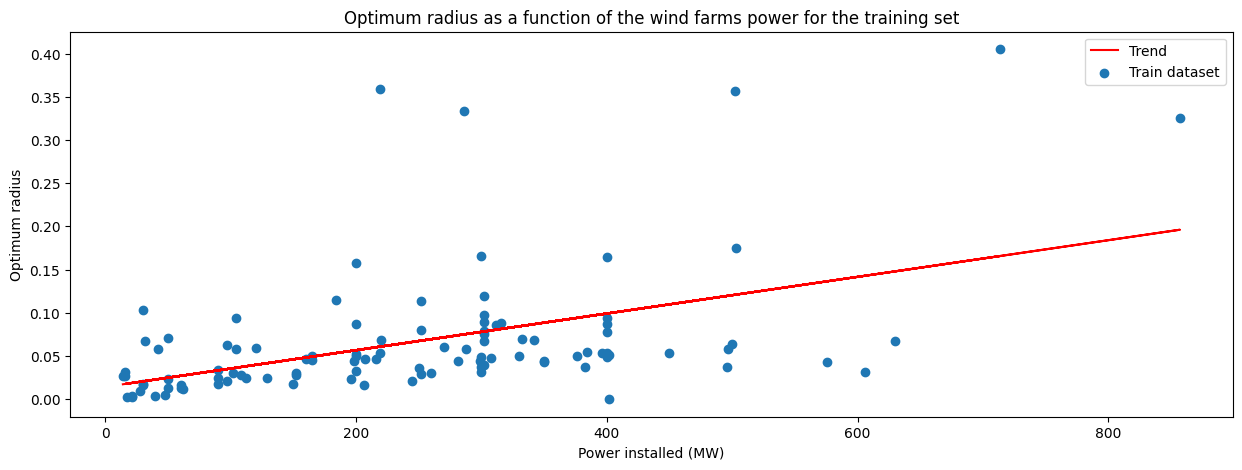

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
reg = np.polyfit(train_set["Capacity (MW)"], train_set["Radius"], deg=1)
trend = np.polyval(reg, train_set["Capacity (MW)"])
plt.plot(train_set["Capacity (MW)"], trend, "r", label="Trend")
ax.scatter(train_set["Capacity (MW)"], train_set["Radius"], label="Train dataset")
ax.set_xlabel("Power installed (MW)")
ax.set_ylabel("Optimum radius")
ax.set_title(
    "Optimum radius as a function of the wind farms power for the training set"
)
ax.legend()
fig.savefig("Power vs radius.png")
plt.show()

Calculate the IOU on the validation set with the linear model calculated from the 

In [19]:
def extrapol_radius(sett, regression):
    expected_radius = np.polyval(reg, sett["Capacity (MW)"])
    return expected_radius

In [20]:
def add_expt_r(sett, regression):
    e_r = extrapol_radius(sett, regression)
    sett["Expected radius"] = e_r

In [21]:
add_expt_r(val_set, reg)
val_set.head()

/var/tmp/ipykernel_134942/3648578343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sett["Expected radius"] = e_r


,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy,Square,Poly,Expected radius
2312,China,Guangdong Yangjiang Nanpengdao (China Energy C...,302.0,offshore hard mount,operating,2021.0,21.4140,112.2110,exact,"{""type"": ""Polygon"", ""coordinates"": [[[112.14, ...","[{'type': 'Polygon', 'coordinates': [[[112.181...",0.078380
2349,China,Guangdong Zhuhai Guishan Offshore Wind Demonst...,90.0,offshore hard mount,operating,2021.0,22.1161,113.7236,exact,"{""type"": ""Polygon"", ""coordinates"": [[[113.68, ...","[{'type': 'Polygon', 'coordinates': [[[113.729...",0.033415
1769,China,Fujian Fuqing Haitan Straits Offshore wind farm,299.0,offshore hard mount,operating,2021.0,25.5361,119.6158,exact,"{""type"": ""Polygon"", ""coordinates"": [[[119.5557...","[{'type': 'Polygon', 'coordinates': [[[119.562...",0.077744
8133,China,Zhejiang Cangnan 4 Offshore wind farm,400.0,offshore hard mount,operating,2022.0,27.2750,120.9667,exact,"{""type"": ""Polygon"", ""coordinates"": [[[120.8667...","[{'type': 'Polygon', 'coordinates': [[[120.878...",0.099166
8151,China,Zhejiang Jiaxing 1 Offshore wind farm,300.0,offshore hard mount,operating,2021.0,30.3980,121.4971,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.4, 3...","[{'type': 'Polygon', 'coordinates': [[[121.455...",0.077956


## Calculate the IOU base on the expected radius 

In [61]:
# test = val_set.head(10)

In [62]:
def IOU_from_expected_r(dataset):
    list_iou = IOU_(
        dataset["Longitude"],
        dataset["Latitude"],
        dataset["Poly"],
        dataset["Expected radius"],
    )
    dataset["IOU"] = list_iou

In [63]:
def IOU_(lon_list, lat_list, poly_list, r_list):
    iou_list = []
    for i in range(len(lon_list)):
        circle = sh_geom.Point(lon_list.iloc[i], lat_list.iloc[i]).buffer(
            r_list.iloc[i]
        )
        circle = gpd.GeoSeries([circle])
        gt = eval(poly_list.iloc[i])
        shape = [gpd.GeoSeries(sh_geom.shape(polygon)) for polygon in gt]
        shape = gpd.GeoSeries(pd.concat(shape))
        iou = IOU(circle, shape)
        iou_list.append(iou)
    return iou_list

In [64]:
IOU_from_expected_r(val_set)
val_set

/var/tmp/ipykernel_134942/3190710686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["IOU"] = list_iou


,Country,Project Name,Capacity (MW),Installation Type,Status,Start year,Latitude,Longitude,Location accuracy,Square,Poly,Expected radius,IOU
2312,China,Guangdong Yangjiang Nanpengdao (China Energy C...,302.0,offshore hard mount,operating,2021.0,21.4140,112.2110,exact,"{""type"": ""Polygon"", ""coordinates"": [[[112.14, ...","[{'type': 'Polygon', 'coordinates': [[[112.181...",0.078380,0.287886
2349,China,Guangdong Zhuhai Guishan Offshore Wind Demonst...,90.0,offshore hard mount,operating,2021.0,22.1161,113.7236,exact,"{""type"": ""Polygon"", ""coordinates"": [[[113.68, ...","[{'type': 'Polygon', 'coordinates': [[[113.729...",0.033415,0.358831
1769,China,Fujian Fuqing Haitan Straits Offshore wind farm,299.0,offshore hard mount,operating,2021.0,25.5361,119.6158,exact,"{""type"": ""Polygon"", ""coordinates"": [[[119.5557...","[{'type': 'Polygon', 'coordinates': [[[119.562...",0.077744,0.031786
8133,China,Zhejiang Cangnan 4 Offshore wind farm,400.0,offshore hard mount,operating,2022.0,27.2750,120.9667,exact,"{""type"": ""Polygon"", ""coordinates"": [[[120.8667...","[{'type': 'Polygon', 'coordinates': [[[120.878...",0.099166,0.145758
8151,China,Zhejiang Jiaxing 1 Offshore wind farm,300.0,offshore hard mount,operating,2021.0,30.3980,121.4971,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.4, 3...","[{'type': 'Polygon', 'coordinates': [[[121.455...",0.077956,0.118865
5369,China,Jiangsu Rudong H8 Offshore wind farm,300.0,offshore hard mount,operating,2021.0,32.7501,121.9333,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.9100...","[{'type': 'Polygon', 'coordinates': [[[121.911...",0.077956,0.085774
5295,China,Jiangsu Dongtai (Jiangsu Guangheng) Offshore w...,200.0,offshore hard mount,operating,2017.0,32.9348,121.1359,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.19, ...","[{'type': 'Polygon', 'coordinates': [[[121.195...",0.056746,0.000000
5281,China,Jiangsu Dafeng H5 Offshore wind farm,206.0,offshore hard mount,operating,2021.0,33.5096,121.3750,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435...",0.058019,0.213684
5274,China,Jiangsu Dafeng H12 Offshore wind farm,200.0,offshore hard mount,operating,2018.0,33.3083,121.1333,exact,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.233...",0.056746,0.144460
5404,China,Jiangsu Xiangshui Near-Ocean Ofshore wind farm,202.0,offshore hard mount,operating,2016.0,34.5030,120.0518,exact,"{""type"": ""Polygon"", ""coordinates"": [[[119.9618...","[{'type': 'Polygon', 'coordinates': [[[119.994...",0.057170,0.246126


In [66]:
val_set["IOU"].mean()

0.16439926042739886

In [10]:
# gt = eval(active_offshore_db_accurate.iloc[6]["Poly"])
# shape = [gpd.GeoSeries(sh_geom.shape(polygon)) for polygon in gt]
# shape = gpd.GeoSeries(pd.concat(shape))

In [92]:
# iou_max = 0
# optim_r = 0
# for radius in np.arange(start=0, stop=0.7, step=0.001):
#     circle = sh_geom.Point(
#         active_offshore_db_accurate.iloc[6]["Longitude"],
#         active_offshore_db_accurate.iloc[6]["Latitude"],
#     ).buffer(radius)
#     circle = gpd.GeoSeries([circle])
#     iou = IOU(circle, shape)
#     if iou > iou_max:
#         iou_max = iou
#         optim_r = radius
# print(iou_max, optim_r)

In [106]:
# circle = sh_geom.Point(
#     active_offshore_db_accurate.iloc[6]["Longitude"],
#     active_offshore_db_accurate.iloc[6]["Latitude"],
# ).buffer(0.04)
# circle = gpd.GeoSeries([circle])

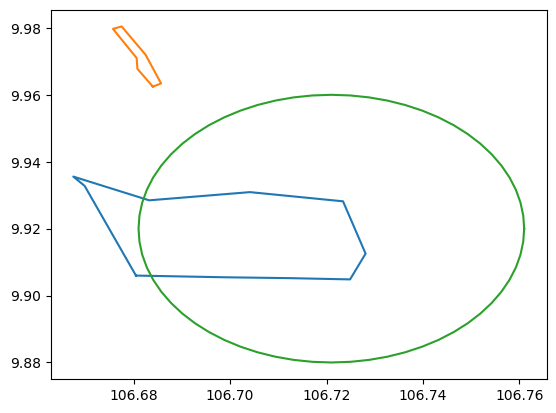

In [107]:
# fig, ax = plt.subplots()
# for sh in shape:
#     ax.plot(*sh.exterior.xy)
# ax.plot(*circle.iloc[0].exterior.xy)
# plt.show()

In [110]:
circle[0].intersection(shape.iloc[1])

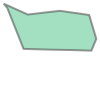

In [101]:
shape.iloc[0]

In [126]:
intersection_area = sum(
    [circle.intersection(shape.iloc[i]).area for i in range(len(shape))]
).item()
intersection_area

0.0010694597773263494

In [72]:
intersection_area

0    POLYGON ((106.66982 9.93277, 106.66746 9.93556...
0    POLYGON ((106.68294 9.96638, 106.68420 9.96732...
dtype: geometry

In [74]:
intersection_area = circle.intersection(shape).area.sum()
intersection_area

/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0.0012446126192121282

In [87]:
intersection_area = circle.intersection(shape).area.sum()
union_area = circle.area.sum() + shape.area.sum() - intersection_area
iou = intersection_area / union_area

/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [90]:
iou

0.1098951514367346

In [80]:
IOU(circle, shape)

/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0.1098951514367346